In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

In [4]:
tf.config.set_visible_devices(
    physical_devices[1], 'GPU'
)

# Data Loading

Pre-processing data details:
* Each RGB image was preprocessed by resizing the smallest dimension to 256, cropping the center $256 \times 256$ region, subtracting the per-pixel mean (across
all images) and then using 10 different sub-crops of size $224 \times 224$ (corners + center with(out) horizontal flips).

In [5]:
path_train = 'CINIC10/train/'
path_val = 'CINIC10/valid/'
path_test = 'CINIC10/test/'
data_dir_train = pathlib.Path(path_train)
data_dir_val = pathlib.Path(path_val)
data_dir_test = pathlib.Path(path_test)

In [6]:
list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_val/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*')])

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [9]:
def decode_img(img, dsize):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [dsize[0], dsize[1]])

In [10]:
def process_path(file_path):
    size = (226,226)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img,size )
    return img, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_valid = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [14]:
def augmentation(x, y):
    x = tf.image.random_flip_left_right(x)
    return x, y

In [15]:
def prepare_for_training(ds,training = False, cache=True, shuffle_buffer_size=1000, batch_size = 128):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.map(normalize)
    if training:
        ds = ds.map(augmentation)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [16]:
train_ds = prepare_for_training(labeled_ds_train, training = True, batch_size=64)
val_ds = prepare_for_training(labeled_ds_valid, batch_size=64)
test_ds = prepare_for_training(labeled_ds_test, batch_size=64)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# ZFNet Details

* This architecture was built based on AlexNet, by visualizing the features in a fully AlexNet trained model
* optimizer = SGD 
* batch_size = 128 
* momentum = 0.9 
* weight decay = 0.0005 
* weights initialization = 10e-2 and Bias = 0
* lr_initial = 0.01 (reduced three time prior termination) 
* num_epochs = 70
* cross-entropy loss 

# Model Definition

In [22]:
def Model(num_classes=1000):
    kernel_init = tf.keras.initializers.GlorotNormal()
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(96, kernel_size=(7,7), kernel_initializer = kernel_init,strides = (2,2), activation = 'relu',input_shape = (226,226,3)),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides = (2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256,kernel_size=(5,5), kernel_initializer = kernel_init, strides=(2,2), activation = 'relu'),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(384, kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(384,kernel_size=(3,3), kernel_initializer = kernel_init, padding='same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, kernel_size=(3,3), kernel_initializer = kernel_init,padding='same', activation = 'relu'),
        tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096,activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4096,activation= 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_classes,activation = 'softmax')
    ])
    return model

In [23]:
model = Model(num_classes=10)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 110, 110, 96)      14208     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 96)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 54, 54, 96)        384       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 12, 12, 256)       1024      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 384)      

# Training 

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer=tfa.optimizers.SGDW(learning_rate=0.01, weight_decay=0.0005, momentum=0.9),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_ds,
                   epochs = 70,
                   steps_per_epoch = 100,
                   verbose = 1,
                   validation_data = val_ds,
                   validation_steps=100)

Train for 100 steps, validate for 100 steps
Epoch 1/70
100/100 [==============================] - 12s 118ms/step - loss: 3.3076 - accuracy: 0.2194 - val_loss: 18.5445 - val_accuracy: 0.1214
Epoch 2/70
100/100 [==============================] - 10s 103ms/step - loss: 3.3733 - accuracy: 0.2522 - val_loss: 4.3730 - val_accuracy: 0.2678
Epoch 3/70
100/100 [==============================] - 11s 106ms/step - loss: 3.1419 - accuracy: 0.2653 - val_loss: 2.7460 - val_accuracy: 0.2962
Epoch 4/70
100/100 [==============================] - 10s 103ms/step - loss: 2.9755 - accuracy: 0.2789 - val_loss: 2.5070 - val_accuracy: 0.2403
Epoch 5/70
100/100 [==============================] - 10s 101ms/step - loss: 2.7016 - accuracy: 0.3047 - val_loss: 1.9568 - val_accuracy: 0.3202
Epoch 6/70
100/100 [==============================] - 10s 103ms/step - loss: 2.6405 - accuracy: 0.3027 - val_loss: 2.3233 - val_accuracy: 0.3028
Epoch 7/70
100/100 [==============================] - 10s 101ms/step - loss: 2.4750 -

# Evaluation

In [27]:
loss_test, accuracy_test = model.evaluate(test_ds, verbose = 1, steps = 5)

5/5 [==============================] - 8s 2s/step - loss: 1.0459 - accuracy: 0.6469


In [28]:
loss_test, accuracy_test

(1.0458523511886597, 0.646875)

# Training results visualization

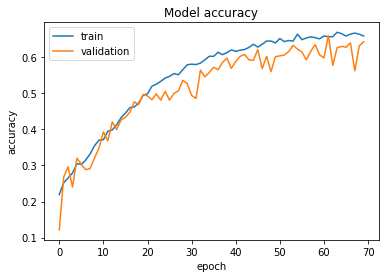

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

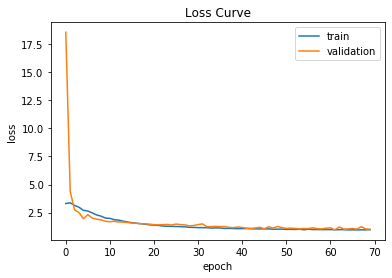

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()